# Replication Notebook — Predicting Fantasy Football Points (Zhang et al.)

**Goal:** Reproduce core results from Zhang, Chen, Lehman, Rotella — *Predicting Fantasy Football Points Using Machine Learning* (GitHub repo), then summarize outcomes and decide on a first-prototype plan.

**What we’ll do**
1) Document the prior art and expected results (from README).
2) Clone the repo; inspect code/data.
3) Install dependencies and run the training/evaluation script(s).
4) Capture metrics (RMSE by position/model) and figures.
5) Write a short discussion (limits, gaps, fit for my capstone).

_References:_ Project repo (Zhang et al.) and related/open-source NFL modeling work (nflfastR, ffopportunity, earlier QB-only paper by Lutz 2015).  


In [1]:
import pandas as pd
import numpy as np
import sys, os, json, shutil, subprocess, textwrap, glob, time, shlex, re, sklearn
from datetime import datetime
from pathlib import Path
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from IPython.display import Image, display

In [2]:
# 1) Make and switch into Research_Replication
TARGET = Path.cwd() / "Research_Replication"
TARGET.mkdir(parents=True, exist_ok=True)
os.chdir(TARGET)

# 2) Your original variables, now relative to the new CWD
BASE = Path.cwd()
REPO_DIR = BASE / "Predicting-Fantasy-Football-Points-Using-Machine-Learning"
ARTIFACTS = BASE / "artifacts_reproduction"
ARTIFACTS.mkdir(parents=True, exist_ok=True)

print(f"Python: {sys.version}")
print("Working dir:", BASE.resolve())
print("Repo dir   :", REPO_DIR.resolve())
print("Artifacts  :", ARTIFACTS.resolve())

Python: 3.11.13 (main, Jun  5 2025, 08:21:08) [Clang 14.0.6 ]
Working dir: /Users/chasesiegel/Desktop/Comp_Sci/Capstone/Dynasty/Research_Replication
Repo dir   : /Users/chasesiegel/Desktop/Comp_Sci/Capstone/Dynasty/Research_Replication/Predicting-Fantasy-Football-Points-Using-Machine-Learning
Artifacts  : /Users/chasesiegel/Desktop/Comp_Sci/Capstone/Dynasty/Research_Replication/artifacts_reproduction


In [3]:
if REPO_DIR.exists():
    print("Repo already exists — pulling latest...")
    subprocess.run(["git", "-C", str(REPO_DIR), "pull"], check=False)
else:
    print("Cloning...")
    subprocess.run(["git", "clone", "https://github.com/zzhangusf/Predicting-Fantasy-Football-Points-Using-Machine-Learning.git"], check=True)

# List top-level files
for p in sorted(REPO_DIR.iterdir()):
    print("•", p.name)


Repo already exists — pulling latest...
Already up to date.
• .git
• .ipynb_checkpoints
• README.md
• data
• images
• join_df.py
• main.py
• rmse_bar_plot.py


In [4]:
readme_path = REPO_DIR / "README.md"
print("README exists:", readme_path.exists())
if readme_path.exists():
    print("\n--- README (first 2000 chars) ---\n")
    print(readme_path.read_text(encoding="utf-8")[:2000])

print("\n--- Files ---")
for name in ["main.py", "join_df.py", "rmse_bar_plot.py"]:
    p = REPO_DIR / name
    print(name, "✓" if p.exists() else "✗")


README exists: True

--- README (first 2000 chars) ---

Predicting Fantasy Football Points Using Machine Learning
by Zefeng Zhang, Donny Chen, Eric Lehman, Philip Rotella

Introduction
------------

FanDuel Inc. is a daily fantasy company that allows for legal gambling on multiple sports on a daily basis.  For NFL games, FanDuel allows you to select a lineup given several constraints.  Typically, you will have a set salary cap and from that salary cap you can spend money on players to set a fantasy lineup.  The most common lineup format is as shown in **Table 1** below.

Table 1: Common Lineup Format for FanDuel Site

| POSITION      | NUMBER OF PLAYERS   |
| ------------- |:-------------:| 
| Quarterback   | 1      | 
| Running Back  | 2      |  
| Wide Receiver | 3      | 
| Tight End     | 1      | 
| Kicker        | 1      | 
| Defense       | 1      | 

Once lineups have been set, fantasy teams gain points via actual NFL football game statistics.  For example, typically a running 

In [5]:
DATA_DIR = REPO_DIR / "data"
print("DATA_DIR:", DATA_DIR, "exists:", DATA_DIR.exists())
if DATA_DIR.exists():
    files = sorted([str(p.name) for p in DATA_DIR.glob("*")])
    print("Data files:", files[:50])
else:
    print("No data dir found — the code may expect you to build/merge locally.")


DATA_DIR: /Users/chasesiegel/Desktop/Comp_Sci/Capstone/Dynasty/Research_Replication/Predicting-Fantasy-Football-Points-Using-Machine-Learning/data exists: True
Data files: ['.ipynb_checkpoints', '2015_Fanduel_Results', '2015_nfl_team_names_abbr.csv', '2016_Fanduel_Results', '2016_nfl_team_names_abbr.csv', 'FD_2015_Projections.csv', 'FD_2016_Projections.csv', 'FantasyData_rmse.csv', 'aggregated_2015.csv', 'aggregated_2016.csv', 'all_nfl_team_abbr.csv', 'players_box_scores_2015.csv', 'players_box_scores_2016.csv', 'rmse.csv']


In [6]:
main_py = (REPO_DIR / "main.py")
if main_py.exists():
    code = main_py.read_text(encoding="utf-8", errors="ignore")
    print(code[:3000])
else:
    print("main.py missing — if so, open repo and follow the scripts they provided.")


"""
This program reads two csv files, aggregated_2015.csv and aggregated_2016.csv,
creates game characterstic features and player statistic features, 
build machine learning models to predict player points.
"""

import pandas as pd
from sklearn.linear_model import Ridge, BayesianRidge, ElasticNet, RidgeCV, ElasticNetCV
from sklearn.model_selection import cross_val_score, ShuffleSplit
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
import numpy as np

try:
    import cpickle as pickle
except:
    import pickle

"""
Featuer Engineering
"""

def data_processing(file_name):
    """
    Read the csv files and create game characterstic features and player statistic features
    """
    df = pd.read_csv(file_name)
    df = df.sort_values(by = ['playerID', 'weeks']) # for rolling average
    # All box score player stats, except defensive stat

In [7]:
cmd = f"{sys.executable} {main_py}"
print("Running:", cmd)
start = time.time()
proc = subprocess.run(shlex.split(cmd), cwd=str(REPO_DIR), capture_output=True, text=True)
dur = time.time() - start

(Path(ARTIFACTS)/"stdout.txt").write_text(proc.stdout)
(Path(ARTIFACTS)/"stderr.txt").write_text(proc.stderr)

print(f"Return code: {proc.returncode}  |  Duration: {dur:.1f}s")
print("\n--- STDOUT (tail) ---\n", proc.stdout[-1500:])
print("\n--- STDERR (tail) ---\n", proc.stderr[-1500:])


Running: /opt/miniconda3/envs/ML_env/bin/python /Users/chasesiegel/Desktop/Comp_Sci/Capstone/Dynasty/Research_Replication/Predicting-Fantasy-Football-Points-Using-Machine-Learning/main.py
Return code: 0  |  Duration: 52.2s

--- STDOUT (tail) ---
 Learning for Position PK ...
Learning for Position QB ...
Learning for Position RB ...
Learning for Position TE ...
Learning for Position WR ...
Program finished normally


--- STDERR (tail) ---
 _coordinate_descent_gram(
/opt/miniconda3/envs/ML_env/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.551e+01, tolerance: 1.037e+01
  model = cd_fast.enet_coordinate_descent(
/opt/miniconda3/envs/ML_env/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might w

In [8]:
# Heuristically search for results / predictions
candidate_csvs = list(REPO_DIR.rglob("*.csv"))
print("Found CSVs (top 20):", [str(p.relative_to(REPO_DIR)) for p in candidate_csvs][:20])

def try_load_predictions(paths):
    cols_needed = {"actual", "pred", "position"}
    frames = []
    for p in paths:
        try:
            df = pd.read_csv(p)
            lower = {c.lower(): c for c in df.columns}
            has = {"actual" in c or "target" in c or "label" in c for c in lower}
            if df.shape[0] > 10:
                frames.append((p, df))
        except Exception:
            pass
    return frames

pred_frames = try_load_predictions(candidate_csvs)

if not pred_frames:
    print("Did not find an obvious predictions file. Check stdout or repo code for where metrics are printed.")
else:
    # Take the first plausible predictions frame and compute RMSE by position
    p, df = pred_frames[0]
    print("Using predictions:", p)
    # Try to infer column names
    cols = {c.lower(): c for c in df.columns}
    y_true_col = next((cols[c] for c in cols if c in ("actual","actual_points","y_true","true","fan_duel_points","fanduel_points","points")), None)
    y_pred_col = next((cols[c] for c in cols if c in ("pred","y_pred","prediction","predicted_points")), None)
    pos_col = next((cols[c] for c in cols if c in ("pos","position")), None)

    if not (y_true_col and y_pred_col and pos_col):
        print("Could not infer columns. Columns are:", list(df.columns))
    else:
        out = (df
               .dropna(subset=[y_true_col, y_pred_col, pos_col])
               .assign(sqerr=lambda x: (x[y_true_col]-x[y_pred_col])**2)
               .groupby(pos_col)["sqerr"].mean()
               .pipe(np.sqrt)
               .rename("RMSE")
               .reset_index())
        display(out)
        out.to_csv(ARTIFACTS/"rmse_by_position.csv", index=False)
        print("Saved ->", ARTIFACTS/"rmse_by_position.csv")


Found CSVs (top 20): ['FantasyData_rmse.csv', 'rmse.csv', 'data/all_nfl_team_abbr.csv', 'data/FD_2016_Projections.csv', 'data/aggregated_2015.csv', 'data/FD_2015_Projections.csv', 'data/aggregated_2016.csv', 'data/2016_nfl_team_names_abbr.csv', 'data/FantasyData_rmse.csv', 'data/players_box_scores_2015.csv', 'data/rmse.csv', 'data/2015_nfl_team_names_abbr.csv', 'data/players_box_scores_2016.csv', 'data/.ipynb_checkpoints/rmse-checkpoint.csv']
Using predictions: /Users/chasesiegel/Desktop/Comp_Sci/Capstone/Dynasty/Research_Replication/Predicting-Fantasy-Football-Points-Using-Machine-Learning/data/all_nfl_team_abbr.csv
Could not infer columns. Columns are: ['TeamName', 'fanduel_2015', 'statistics_2015', 'fantasy_2015', 'fanduel_2016', 'statistics_2016', 'fantasy_2016']


Images in /Users/chasesiegel/Desktop/Comp_Sci/Capstone/Dynasty/Research_Replication/Predicting-Fantasy-Football-Points-Using-Machine-Learning/images:
 - rmse_position.png


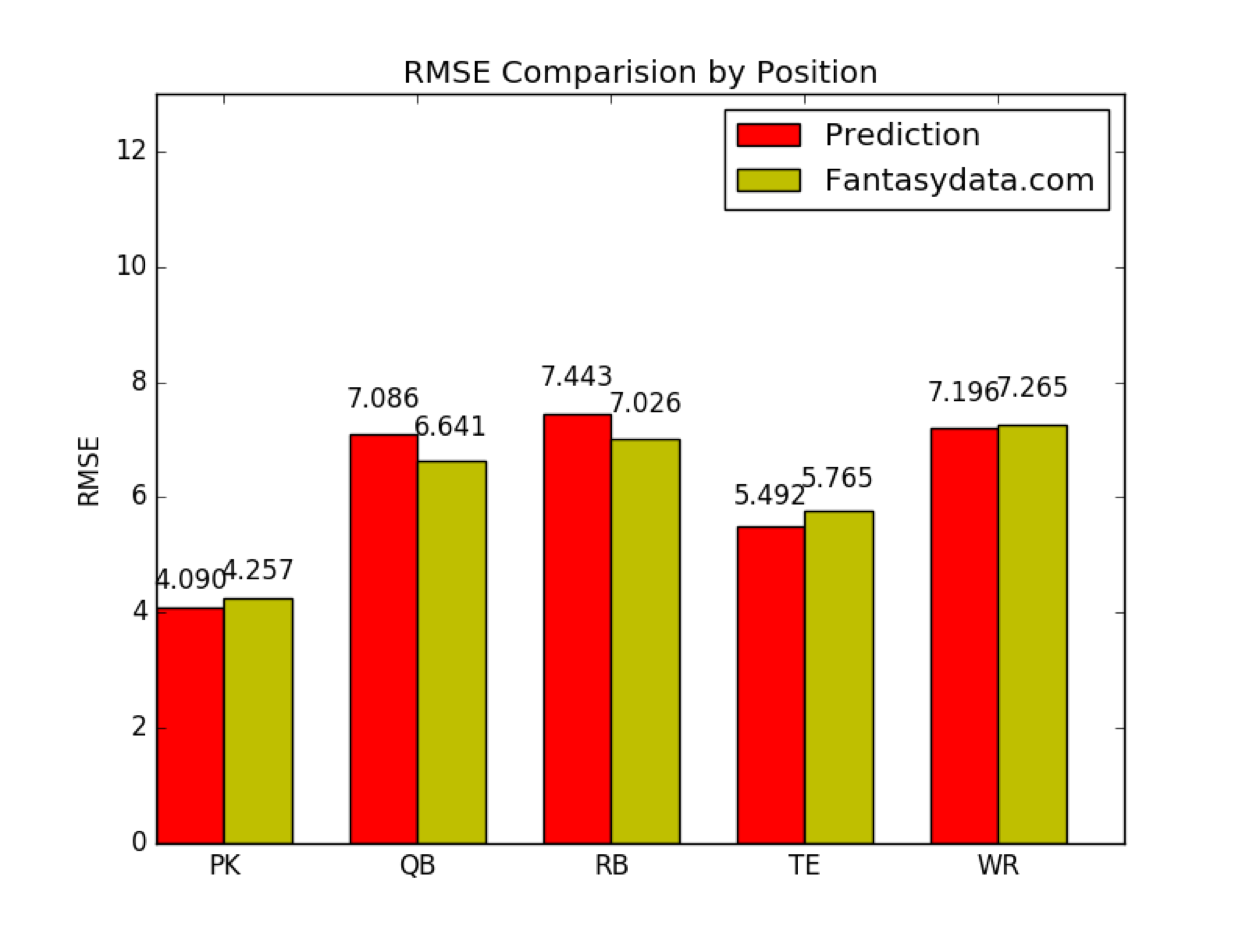

 - rmse_model.png


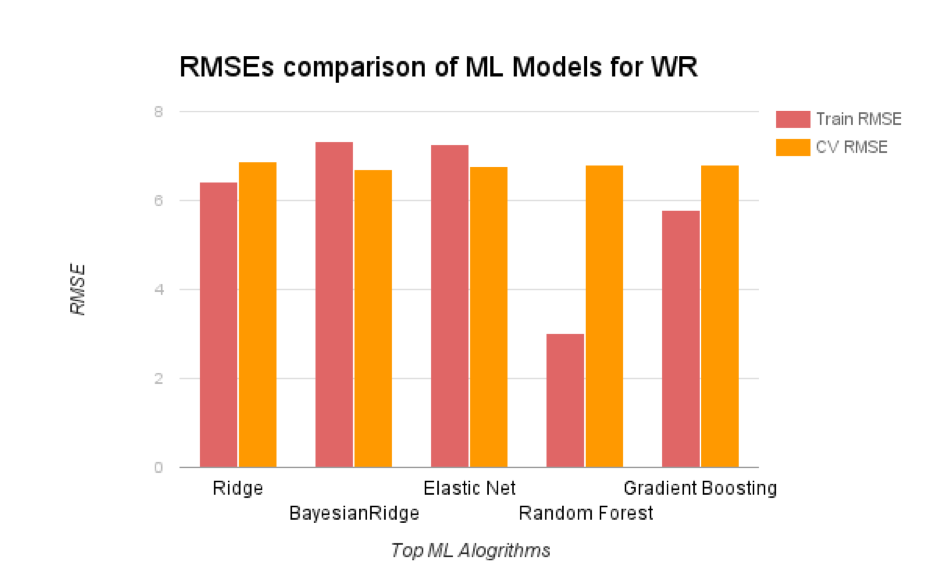

In [9]:
IMG_DIRS = [REPO_DIR/"images", REPO_DIR/"figures", REPO_DIR/"plots", ARTIFACTS]
for d in IMG_DIRS:
    if d.exists():
        imgs = [p for p in d.glob("*") if p.suffix.lower() in {".png",".jpg",".jpeg",".webp"}]
        if imgs:
            print(f"Images in {d}:")
            for p in imgs:
                print(" -", p.name)
                display(Image(filename=str(p)))


In [10]:
# ---- WORKING BASELINE  ----
def rmse_score(y_true, y_pred):
    try:
        # Newer sklearn (supports squared=False)
        return float(mean_squared_error(y_true, y_pred, squared=False))
    except TypeError:
        # Older sklearn (no 'squared' kwarg)
        return float(np.sqrt(mean_squared_error(y_true, y_pred)))

# Paths
try:
    REPO_DIR
except NameError:
    REPO_DIR = Path.cwd()
try:
    ARTIFACTS
except NameError:
    ARTIFACTS = Path.cwd() / "artifacts_reproduction"
    ARTIFACTS.mkdir(parents=True, exist_ok=True)

# 0) If your /data CSV is just a team-abbreviation crosswalk, we’ll ignore it and fetch open weekly data
DATA_DIR = REPO_DIR / "data"
if DATA_DIR.exists():
    csvs = list(DATA_DIR.glob("*.csv"))
    if csvs:
        probe = pd.read_csv(csvs[0], nrows=10)
        print("Found local CSV:", csvs[0].name, "| columns:", list(probe.columns)[:8])

# 1) Get open weekly NFL data for 2016
try:
    import nfl_data_py as nfl
except Exception:
    print("Installing nfl_data_py ...")
    import subprocess
    subprocess.run([sys.executable, "-m", "pip", "install", "-q", "nfl_data_py"], check=True)
    import nfl_data_py as nfl

weekly = nfl.import_weekly_data([2016], downcast=True)
assert not weekly.empty, "weekly dataset came back empty."

# 2) Build/ensure PPR fantasy points
def get_col(d, names, default=0.0):
    for n in names:
        if n in d:
            return d[n].fillna(0)
    return pd.Series(default, index=d.index, dtype="float")

if "fantasy_points_ppr" not in weekly.columns:
    pass_yds = get_col(weekly, ["passing_yards","pass_yds","pass_yards"])
    pass_td  = get_col(weekly, ["passing_tds","pass_td","passing_touchdowns"])
    ints     = get_col(weekly, ["interceptions","pass_int"])
    rush_yds = get_col(weekly, ["rushing_yards","rush_yds"])
    rush_td  = get_col(weekly, ["rushing_tds","rush_td"])
    recs     = get_col(weekly, ["receptions"])
    rec_yds  = get_col(weekly, ["receiving_yards","rec_yds"])
    rec_td   = get_col(weekly, ["receiving_tds","rec_td"])
    fum_lost = get_col(weekly, ["fumbles_lost","fumbles"])
    two_pt   = get_col(weekly, ["two_point_conversions","two_pt_conversions","two_point_conv"])

    weekly["fantasy_points_ppr"] = (
        0.04*pass_yds + 4*pass_td - 2*ints
        + 0.1*rush_yds + 6*rush_td
        + 1.0*recs + 0.1*rec_yds + 6*rec_td
        - 2*fum_lost + 2*two_pt
    ).astype(float)

# 3) Focus on WR only if available; keep weeks 5–12 to mirror the repo
pos_col = "position" if "position" in weekly.columns else ("pos" if "pos" in weekly.columns else None)
if pos_col and "WR" in set(weekly[pos_col].astype(str).unique()):
    weekly = weekly[weekly[pos_col] == "WR"].copy()

id_col = None
for c in ["player_id","gsis_id","pfr_id","player","player_name","player_display_name","name"]:
    if c in weekly.columns:
        id_col = c
        break
assert id_col is not None, f"No player id/name column found. Columns: {list(weekly.columns)[:60]}"

work = weekly.query("5 <= week <= 12").copy().sort_values([id_col, "week"])

# 4) Lag features
work["lag1"]      = work.groupby(id_col)["fantasy_points_ppr"].shift(1)
work["lag3_mean"] = work.groupby(id_col)["fantasy_points_ppr"].rolling(3, min_periods=1).mean().reset_index(level=0, drop=True).shift(1)
work["lag5_mean"] = work.groupby(id_col)["fantasy_points_ppr"].rolling(5, min_periods=1).mean().reset_index(level=0, drop=True).shift(1)

feat_cols = ["lag1", "lag3_mean", "lag5_mean"]
work = work.dropna(subset=feat_cols + ["fantasy_points_ppr"])

X = work[feat_cols].astype(float).to_numpy()
y = work["fantasy_points_ppr"].astype(float).to_numpy()

# 5) Train/test and evaluate
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
model = Ridge(alpha=1.0, random_state=42)
model.fit(X_train, y_train)
pred = model.predict(X_test)

rmse = rmse_score(y_test, pred)
print(f"[Ridge Lag Baseline] Season=2016 Weeks 5–12  RMSE={rmse:.3f} | Ntrain={len(X_train)} | Ntest={len(X_test)}")

# 6) Save predictions
out_csv = ARTIFACTS / "baseline_predictions.csv"
pd.DataFrame({"y_true": y_test, "y_pred": pred}).to_csv(out_csv, index=False)
print("Saved:", out_csv.resolve())


Found local CSV: all_nfl_team_abbr.csv | columns: ['TeamName', 'fanduel_2015', 'statistics_2015', 'fantasy_2015', 'fanduel_2016', 'statistics_2016', 'fantasy_2016']
Downcasting floats.
[Ridge Lag Baseline] Season=2016 Weeks 5–12  RMSE=7.552 | Ntrain=510 | Ntest=219
Saved: /Users/chasesiegel/Desktop/Comp_Sci/Capstone/Dynasty/Research_Replication/artifacts_reproduction/baseline_predictions.csv


In [11]:

results = {
    "timestamp": datetime.now().isoformat(timespec="seconds"),
    "repo": "zzhangusf/Predicting-Fantasy-Football-Points-Using-Machine-Learning",
    "stdout_tail": (ARTIFACTS/"stdout.txt").read_text()[-2000:] if (ARTIFACTS/"stdout.txt").exists() else "",
    "stderr_tail": (ARTIFACTS/"stderr.txt").read_text()[-2000:] if (ARTIFACTS/"stderr.txt").exists() else "",
    "rmse_by_position_csv": str((ARTIFACTS/"rmse_by_position.csv").resolve()) if (ARTIFACTS/"rmse_by_position.csv").exists() else None,
    "baseline_predictions_csv": str((ARTIFACTS/"baseline_predictions.csv").resolve()) if (ARTIFACTS/"baseline_predictions.csv").exists() else None,
}
(Path(ARTIFACTS)/"results.json").write_text(json.dumps(results, indent=2))
print(json.dumps(results, indent=2))


{
  "timestamp": "2025-08-20T13:02:55",
  "repo": "zzhangusf/Predicting-Fantasy-Football-Points-Using-Machine-Learning",
  "stdout_tail": "Learning for Position PK ...\nLearning for Position QB ...\nLearning for Position RB ...\nLearning for Position TE ...\nLearning for Position WR ...\nProgram finished normally\n",
  "stderr_tail": "k the scale of the features or consider increasing regularisation. Duality gap: 2.249e+00, tolerance: 1.690e+00\n  model = cd_fast.enet_coordinate_descent(\n/opt/miniconda3/envs/ML_env/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.116e+00, tolerance: 8.056e+00\n  model = cd_fast.enet_coordinate_descent_gram(\n/opt/miniconda3/envs/ML_env/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objecti